Search 1 | BE2 = -0.4 eV, Lambda = (1.1842262255932274+0j)
Search 2 | BE2 = -0.5 eV, Lambda = (0.990377117693416+0j)
Search 3 | BE2 = -0.4950358903320012 eV, Lambda = (0.9983492482133+0j)
Search 4 | BE2 = -0.49400799535670126 eV, Lambda = (1.0000177647415915+0j)
Search 5 | BE2 = -0.49401893938291247 eV, Lambda = (0.9999999675417672+0j)
Search 6 | BE2 = -0.4940189194233821 eV, Lambda = (0.999999999999365+0j)

Computed Energy: -0.4940189194233821 eV
<H0> 1.209228e-01
<V>  -6.149417e-01
<H>  -4.940189e-01
Error: 0.000000000%


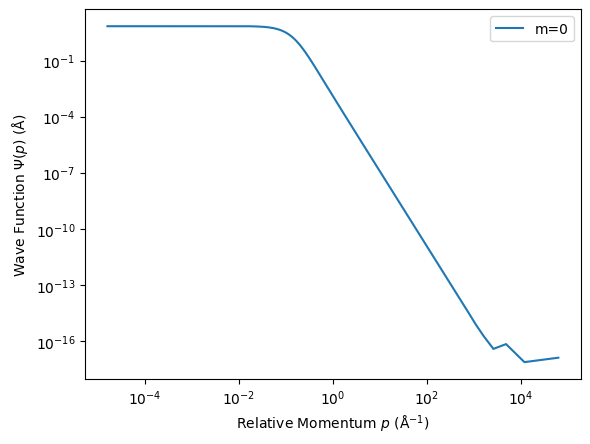

In [ ]:
# This code solves the Schrödinger equation for a 2D exciton
# (electron–hole pair) with a Rytova–Keldysh (RK) potential.
# It calculates the binding energies and wave functions
# for different partial wave quantum numbers m_angular.
#
# The numerical solution is obtained in momentum space using a
# Lippmann–Schwinger (LS) integral equation approach.
#
# Author: Mohammadreza Hadizadeh (mhadizadeh@centralstate.edu)
# February 2025.
#
# Please cite the companion article if you use this resource:
# K. Adderley, K. Mohseni, and M. R. Hadizadeh,
# “Open-source interactive website for exciton modeling via the Lippmann–Schwinger equation” (2025),
# URL: https://csu-physics.github.io/2B_2D/.

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import roots_legendre
from scipy.sparse.linalg import eigs

# ----------------------------------------------------------------------
# Matplotlib style: more professional / publication-ready defaults
# ----------------------------------------------------------------------
plt.rcParams.update({
    "figure.figsize": (6, 4),      # Figure size in inches
    "figure.dpi": 150,             # Resolution
    "axes.labelsize": 14,          # Font size for x/y labels
    "axes.titlesize": 14,          # Font size for titles
    "xtick.labelsize": 12,         # Font size for x tick labels
    "ytick.labelsize": 12,         # Font size for y tick labels
    "legend.fontsize": 12,         # Font size for legends
    "lines.linewidth": 2,          # Thicker lines
    "axes.grid": False,            # Grid off by default (can be turned on if desired)
})

# ----------------------------------------------------------------------
# Global numerical parameters and physical constants
# ----------------------------------------------------------------------
Np = 400          # Number of momentum grid points (radial momentum p)
Nphi = 100        # Number of angular points (phi) for angle integration
pi = np.pi
ONE = 1.0
ZERO = 0.0
Tol_lambda = 1.0e-10   # Convergence tolerance for eigenvalue Lambda ≈ 1
m_angular = 0          # Orbital quantum number (partial wave index m)

# Fundamental constants and material parameters
hc = 1973.2698040  # eV·Å, Planck constant times c in convenient units

# Coulomb-related constants
K_coul = 14.3996   # Coulomb constant in eV·Å·e^−2
ez = 1.0 / (4.0 * pi * K_coul)  # Vacuum permittivity in eV^-1·Å^-1 (not directly used)
alpha_inv = 137.035999084       # Inverse fine structure constant (dimensionless)
ez_e2 = alpha_inv / (4.0 * pi * hc)  # ez / e^2 in eV^-1·Å^-1 (used in RK potential)

# Electron and hole effective masses in MoSe2
me = 0.510998950 * 1e6  # Electron rest mass in eV
m_e = 0.4700 * me       # Electron effective mass in MoSe2 (in eV)
m_h = 0.5400 * me       # Hole effective mass in MoSe2 (in eV)

# Convert masses from eV to eV^-1·Å^-2 using hc (since p is in Å^-1)
mass_e = m_e / hc**2
mass_h = m_h / hc**2

# Reduced mass μ of the electron–hole pair (exciton) and corresponding "two-body mass"
mu = mass_e * mass_h / (mass_e + mass_h)  # e–h reduced mass
mass = 2.0 * mu                           # Effective mass in LS equation

# Screening length r_0 for MoSe2 in Å (Rytova–Keldysh parameter)
r_0 = 44.6814  # Å

# Initial binding energy guesses for the exciton (in eV)
# These bracket the expected ground-state binding energy.
BE2_1 = -520.00e-3  # eV: Lower bound for energy estimate
BE2_2 = -540.00e-3  # eV: Upper bound for energy estimate

# -----------------------
# Subroutines and Functions
# -----------------------
def hyperbolic(Np):
    """
    Generate a non-uniform (hyperbolic) momentum grid and associated weights
    using Gauss–Legendre quadrature on [-1, 1] mapped to (0, ∞).

    Args:
        Np (int): Number of momentum points.

    Returns:
        (P, dP):
            P  (np.ndarray): Momentum grid points (Np,)
            dP (np.ndarray): Corresponding integration weights for ∫ dp
    """
    # X: standard Gauss–Legendre points in [-1, 1]
    # dX: corresponding weights
    X, dX = roots_legendre(Np)

    # Map X ∈ (-1, 1) → P ∈ (0, ∞) with a hyperbolic mapping
    P = (1.0 + X) / (1.0 - X)

    # Compute the Jacobian factor for the transformation
    dP = 2.0 / (1.0 - X)**2 * dX
    return P, dP

def linear(Nphi, a, b):
    """
    Generate a Gauss–Legendre angular grid and weights over an interval [a, b].

    Args:
        Nphi (int): Number of angular points.
        a (float): Start of the interval.
        b (float): End of the interval.

    Returns:
        (x, dx):
            x  (np.ndarray): Angular grid points mapped from [-1, 1] to [a, b]
            dx (np.ndarray): Integration weights for ∫ dx on [a, b]
    """
    X, dX = roots_legendre(Nphi)

    # Map from [-1, 1] to [a, b]
    x = (b - a) / 2 * X + (b + a) / 2
    dx = (b - a) / 2 * dX
    return x, dx

def eigenvalue(Mmatrix):
    """
    Compute eigenvalues and eigenvectors of the LS kernel matrix Mmatrix, and
    return the eigenvector whose eigenvalue is closest to 1.

    The equation is Mmatrix * WF = Lambda * WF, and bound states correspond to
    Lambda → 1 for the correct binding energy.

    Args:
        Mmatrix (np.ndarray): Square matrix of dimension (Np, Np).

    Returns:
        WF (np.ndarray): Eigenvector (wave function in momentum space) with
                         eigenvalue closest to 1 (absolute value taken).
        Lambda (complex): Corresponding eigenvalue.
    """
    # Dimension of the kernel matrix
    dim_Mmatrix = Mmatrix.shape[0]

    # Number of eigenvalues/eigenvectors to compute
    NEV = 10
    NCV = 2 * NEV  # Number of Arnoldi vectors; > NEV for stability

    # 'LR' = Largest Real part, suitable when targeting eigenvalues near 1
    WHICH = 'LR'

    # Use ARPACK to compute a few eigenvalues and eigenvectors of Mmatrix
    eigenvalues, eigenvectors = eigs(Mmatrix, k=NEV, which=WHICH, ncv=NCV)

    # Look for eigenvalue closest to 1 (fixed point of LS equation)
    target_eigenvalue = 1.0
    idx_min = np.argmin(np.abs(eigenvalues - target_eigenvalue))

    # Select eigenvalue and associated eigenvector
    Lambda = eigenvalues[idx_min]
    WF = np.abs(eigenvectors[:, idx_min])  # Take absolute value to remove arbitrary phase

    return WF, Lambda

def compute_V_2B(Np, Nphi, m_angular, p, xp, phi, dphi):
    """
    Compute the 2D two-body interaction V_2B in momentum space using the
    Rytova–Keldysh (RK) potential, projected onto a given angular momentum m_angular.

    Steps:
      1. Construct a 3D array V_2B[ip, ipp, ixp] = V(p, p', φ)
      2. Perform angular integration over φ with cos(m_angular * φ) to project
         onto the m_angular partial wave, resulting in a 2D matrix V_2B_2d[ip, ipp].

    Args:
        Np (int): Number of radial momentum points.
        Nphi (int): Number of angular points.
        m_angular (int): Angular momentum quantum number m.
        p (np.ndarray): Momentum grid, shape (Np,).
        xp (np.ndarray): cos(φ) values, shape (Nphi,).
        phi (np.ndarray): Angular grid φ, shape (Nphi,).
        dphi (np.ndarray): Angular integration weights, shape (Nphi,).

    Returns:
        V_2B_2d (np.ndarray): Partial-wave projected potential matrix, shape (Np, Np).
    """
    # Initialize the full 3D potential V(p, p', φ)
    V_2B = np.zeros((Np, Np, Nphi))

    # Loop over momentum indices and angles to build V_2B
    for ip in range(Np):
        for ipp in range(Np):
            for ixp in range(Nphi):
                # Momentum transfer magnitude q = |p - p'| (2D version via law of cosines)
                q = np.sqrt(p[ip]**2 + p[ipp]**2
                            - 2.0 * p[ip] * p[ipp] * xp[ixp])

                # RK potential in momentum space:
                # v_term1 carries prefactors, v_term2 contains RK structure ∼ 1/[q (1 + r_0 q)]
                v_term1 = 1.0 / (4.0 * pi * ez_e2)          # eV·Å
                v_term2 = 2.0 * pi / q / (1.0 + r_0 * q)    # Å
                # Overall factor gives V(q) in eV·Å^2
                V_2B[ip, ipp, ixp] = - v_term1 * v_term2 / 4.0 / pi / pi  # eV·Å^2

    # Angular projection onto the m_angular partial wave:
    # V_m(p, p') = ∫ dφ V(p, p', φ) cos(m_angular * φ)
    V_2B_2d = np.zeros((Np, Np))
    cos_terms = np.cos(m_angular * phi)  # cos(m φ) evaluated on the φ grid

    for ipp in range(Np):
        for ip in range(Np):
            # φ integration with Gauss–Legendre weights
            V_2B_2d[ip, ipp] = np.sum(dphi * V_2B[ip, ipp, :] * cos_terms)

    return V_2B_2d

def LS_2D(Np, pp, dp, V_NR, BE2_1, BE2_2):
    """
    Solve the 2D Lippmann–Schwinger equation in momentum space for a given
    partial-wave projected potential V_NR (exciton case).

        M(ip, ipp) = dp[ipp] * pp[ipp] * V_NR[ip, ipp] / (E - pp[ip]^2 / mass)

    We search for a binding energy E = BE2 such that the largest eigenvalue
    Lambda of M(E) satisfies Lambda ≈ 1.

    Args:
        Np (int): Number of momentum points.
        pp (np.ndarray): Momentum grid (Np,).
        dp (np.ndarray): Integration weights for pp (Np,).
        V_NR (np.ndarray): Potential matrix in momentum space (Np, Np).
        BE2_1 (float): First initial guess for the binding energy (eV).
        BE2_2 (float): Second initial guess for the binding energy (eV).

    Returns:
        (BE2, WF):
            BE2 (float): Converged binding energy (eV).
            WF  (np.ndarray): Corresponding normalized wave function in momentum space.
    """
    Ne = 20  # Maximum number of search iterations

    # Arrays to store binding energy guesses and associated eigenvalues Lambda
    BE_ary = np.zeros(Ne)
    Lam_ary = np.zeros(Ne)

    # Seed the first two guesses
    BE_ary[0] = BE2_1
    BE_ary[1] = BE2_2

    for ie in range(Ne):
        # Extrapolation-like update after we have at least two prior points:
        # This tries to accelerate convergence by linearly extrapolating in Lambda.
        if ie > 1:
            BE_ary[ie] = (BE_ary[ie-1]
                          + (1 - Lam_ary[ie-1])/(Lam_ary[ie-2] - Lam_ary[ie-1])
                          * (BE_ary[ie-2] - BE_ary[ie-1]))

        # Current guess for the binding energy
        BE2 = BE_ary[ie]

        # Build the LS kernel matrix Mmatrix(E)
        Mmatrix = np.zeros((Np, Np))
        for ip in range(Np):
            for ipp in range(Np):
                denom = (BE2 - pp[ip]**2 / mass)  # Free Green's function denominator
                if denom != 0:
                    Mmatrix[ip, ipp] = (dp[ipp] * pp[ipp] * V_NR[ip, ipp] / denom)

        # Solve eigenvalue problem M WF = Lambda WF and pick eigenvalue closest to 1
        WF, Lambda = eigenvalue(Mmatrix)

        # Normalize the wave function with respect to the 2D measure:
        # ∫ d^2p |Ψ(p)|^2 = 2π ∫ dp p |Ψ(p)|^2 = 1
        WF /= np.sqrt(np.sum(2.0 * np.pi * WF**2 * dp * pp))

        Lam_ary[ie] = np.real(Lambda)
        print(f"Search {ie+1} | BE2 = {BE2} eV, Lambda = {Lambda}")

        # Convergence criterion on Lambda
        if np.abs(Lambda - 1.0) < Tol_lambda:
            break

    return BE2, WF

def expectation_H0(p, dp, WF, mu):
    """
    Compute the expectation value of the kinetic energy part H0 in 2D momentum space:

        H0 = 2π ∑_i dp[i] * p[i] * (p[i]^2 / (2μ)) * WF[i]^2

    Args:
        p  (np.ndarray): Momentum grid.
        dp (np.ndarray): Momentum weights.
        WF (np.ndarray): Wave function in momentum space.
        mu (float): Reduced mass.

    Returns:
        float: <H0> in eV.
    """
    H0_val = p**2 / (2.0 * mu)         # Kinetic energy p^2 / (2μ)
    integrand = dp * p * H0_val * WF**2
    return 2.0 * np.pi * np.sum(integrand)

def expectation_V(p, dp, WF, V2):
    """
    Compute the expectation value of the two-body potential V in 2D momentum space:

        <V> = 2π ∑_i ∑_j dp[i] p[i] * dp[j] p[j] *
                       V2[i, j] * WF[i] * WF[j]

    Args:
        p  (np.ndarray): Momentum grid.
        dp (np.ndarray): Momentum weights.
        WF (np.ndarray): Wave function in momentum space.
        V2 (np.ndarray): Potential matrix V2(i, j).

    Returns:
        float: <V> in eV.
    """
    Np = p.shape[0]
    V = 0.0
    for i in range(Np):
        wi = dp[i] * p[i] * WF[i]
        for j in range(Np):
            wj = dp[j] * p[j] * WF[j]
            V += wi * wj * V2[i, j]
    return 2.0 * np.pi * V

def compute_H(p, dp, WF, V2):
    """
    Compute expectation values of:
        H0  - kinetic energy operator
        V   - interaction potential
        H   - total Hamiltonian H = H0 + V

    Args:
        p  (np.ndarray): Momentum grid.
        dp (np.ndarray): Momentum weights.
        WF (np.ndarray): Wave function in momentum space.
        V2 (np.ndarray): Potential matrix.

    Returns:
        (H0, V, H): Tuple of expectation values in eV.
    """
    H0 = expectation_H0(p, dp, WF, mu)
    V  = expectation_V(p, dp, WF, V2)
    H  = H0 + V
    return H0, V, H

# -----------------------
# Main Program
# -----------------------
def main():
    # Construct momentum and angular grids
    p, dp   = hyperbolic(Np)               # Radial momentum grid and weights
    phi, dphi = linear(Nphi, 0, 2.0 * pi)  # Angular grid (0 to 2π) and weights
    xp = np.cos(phi)                       # cos(φ), used in q = |p - p'|

    WF_matrix = []  # To store wave functions for different n (if m_angular > 0)

    # Loop over "n" from 0 up to m_angular (here usually only n=0 if m_angular=0)
    for n in range(0, m_angular + 1):
        # Compute partial-wave projected RK potential for given angular momentum n
        V_2B_2d = compute_V_2B(Np, Nphi, n, p, xp, phi, dphi)

        # Solve LS equation to obtain binding energy BE2 and corresponding WF(p)
        BE2, WF = LS_2D(Np, p, dp, V_2B_2d, BE2_1, BE2_2)
        WF_matrix.append(WF)

        print('')
        print(f'Computed Exciton Binding Energy: {BE2} eV')

        # Compute expectation values of H0, V, and H for consistency check
        H0, V, H = compute_H(p, dp, WF, V_2B_2d)

        # Relative percentage difference between <H> and BE2
        error_percent = np.abs((H - BE2) / BE2) * 100.0

        print(f"<H0> = {H0:.6e} eV")
        print(f"<V>  = {V:.6e} eV")
        print(f"<H>  = {H:.6e} eV")
        print(f"Relative Percentage Difference: {error_percent:.9f} %")

        # ------------------------------------------------------------------
        # Plot |Ψ(p)| vs. momentum p – publication-ready style
        # Note: the plotted quantity is the absolute value of the wave function.
        # ------------------------------------------------------------------
        fig, ax = plt.subplots()
        ax.loglog(p, np.abs(WF), label=f'm={m_angular}')
        ax.set_xlabel(r'Relative momentum $p$ (Å$^{-1}$)')
        ax.set_ylabel(r'Wave function $|\Psi(p)|$ (Å)')
        # ax.set_title('Exciton wave function in momentum space (RK potential)')
        ax.legend(frameon=False)
        fig.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()